# Advanced Lane Finding

---

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video.mp4 "Video"

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---

### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

First I prepare object points, that are `x`, `y` and `z` points in the real world of the chessboard corners. I assume that they're all on the `z` plane. Next I loop over each of the images converting them to greyscale. Then I use `cv2.findChessboardCorners` to find the image coordinates of the object points and finally append both to a copy of them. After that I use `cv2.calibrateCamera` to get the camera matrix and distortion coefficients.

In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
# A helper function for showing images
def image_plotter(image, title='', cmap=None, show_axis=False):
    f, ax = plt.subplots(1, 1, figsize=(20,10))
    ax.set_title(title, fontsize=20)
    ax.imshow(image, cmap=cmap)
    if not show_axis:
        ax.set_axis_off()
    plt.show()

In [3]:
# Define number of corners in each direction
rows = 9
cols = 6
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((rows*cols,3), np.float32)
objp[:,:2] = np.mgrid[0:rows,0:cols].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (rows,cols),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
img_shape = img.shape[0:2][::-1]
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)

In [4]:
def undistort(image):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return undist

Example of distortion corrected calibration image

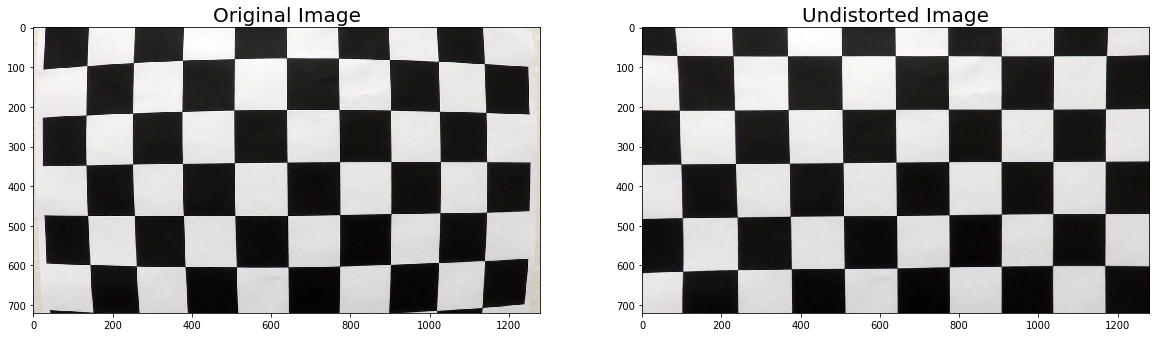

In [5]:
filename = 'camera_cal/calibration1.jpg'
image = mpimg.imread(filename)
undist = undistort(image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(image)
ax2.set_title('Undistorted Image', fontsize=20)
ax2.imshow(undist)
plt.show()

### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.

I use `test_images/test1.jpg` as an example throughout this readme. Below is an example of the distortion-corrected version as well as code to produce it.

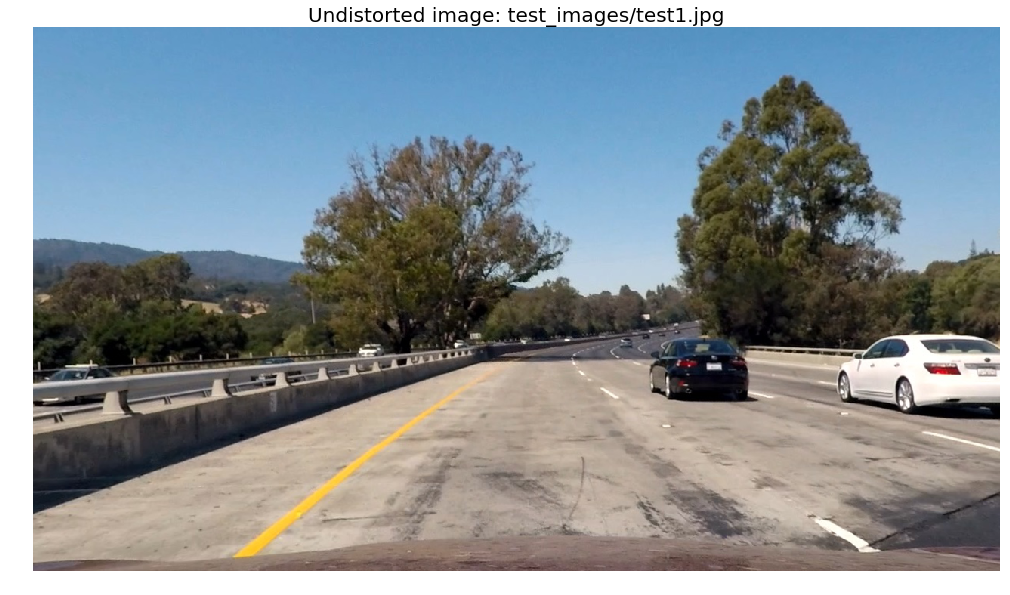

In [6]:
filename = 'test_images/test1.jpg'
image = mpimg.imread(filename)
undist = undistort(image)
image_plotter(undist, title='Undistorted image: {}'.format(filename))

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

First I convert the image to three color spaces, gray, hls and hsv. I'll use these converted images to extract features and combine them later to get the lane lines.

I use a combination of the following channels:
- gray: absolute sobel x direction threshold
- gray: direction threshold
- rgb r: threshold - combined with the one below for yellow lines
- rgb g: threshold
- hls s: threshold
- hls l: threshold
- hsv v: absolute sobel x direction threshold
- hls s: absolute sobel x direction threshold

Some of these are quite noisy under some circumstances. Like shadows from trees or lighter patches of road, but are combined in such a way that the combined version is more stable.

In [7]:
def abs_sobel_thresh(image, orient='x', kernel_size=3, thresh=(0,255)):
    ori = [1, 0] if orient == 'x' else [0, 1]
    sobel = cv2.Sobel(image, cv2.CV_64F, ori[0], ori[1], ksize=kernel_size)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, kernel_size=3, thresh=(0, 255)):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=kernel_size)
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] =1
    return mag_binary

def dir_threshold(image, kernel_size=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=kernel_size)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(dir_sobel)
    dir_binary[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])] =1
    return dir_binary

def thresh(image, thresh=(0, 255)):
    thresh_binary = np.zeros_like(image)
    thresh_binary[(image >= thresh[0]) & (image <= thresh[1])] = 1
    return thresh_binary

def convert_image(image):
    # gray sobel_x & direction
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    gray_x_binary = abs_sobel_thresh(gray, thresh=(10, 200))
    gray_dir_binary = dir_threshold(gray, thresh=(.5, 1.6))
    gray_combined = (gray_x_binary == 1) & (gray_dir_binary == 1)
    
    # yellow lines
    rgb_r = image[:,:,0]
    rgb_g = image[:,:,1]
    rgb_r_binary = thresh(rgb_r, (150, 255))
    rgb_g_binary = thresh(rgb_g, (150, 255))
    rgb_combined = (rgb_r_binary == 1) & (rgb_g_binary == 1)
    
    # Both of these are quite noisy, but are combined below in selector in a way that makes them more stable
    hls_l = hls[:,:,1]
    hls_s = hls[:,:,2]
    hls_l_binary = thresh(hls_l, (120, 255))
    hls_s_binary = thresh(hls_s, (100, 255))
    
    # Adds a little bit of information in highly irregularly shadowed areas like under trees
    hsv_v = hsv[:,:,2]
    hsv_v_sobel_x = abs_sobel_thresh(hsv_v, thresh=(30, 100))
    hls_s_sobel_x = abs_sobel_thresh(hls_s, thresh=(30, 100))
    
    selector = ((rgb_combined == 1) & (hls_l_binary == 1)) & ((hls_s_binary == 1) | (gray_combined == 1)) |\
        (((hsv_v_sobel_x == 1) | (hls_s_sobel_x == 1)))
    
    combined = np.zeros_like(rgb_r)
    combined[selector] = 1
    
    return combined

The same image as above, but as a thresholded binary image

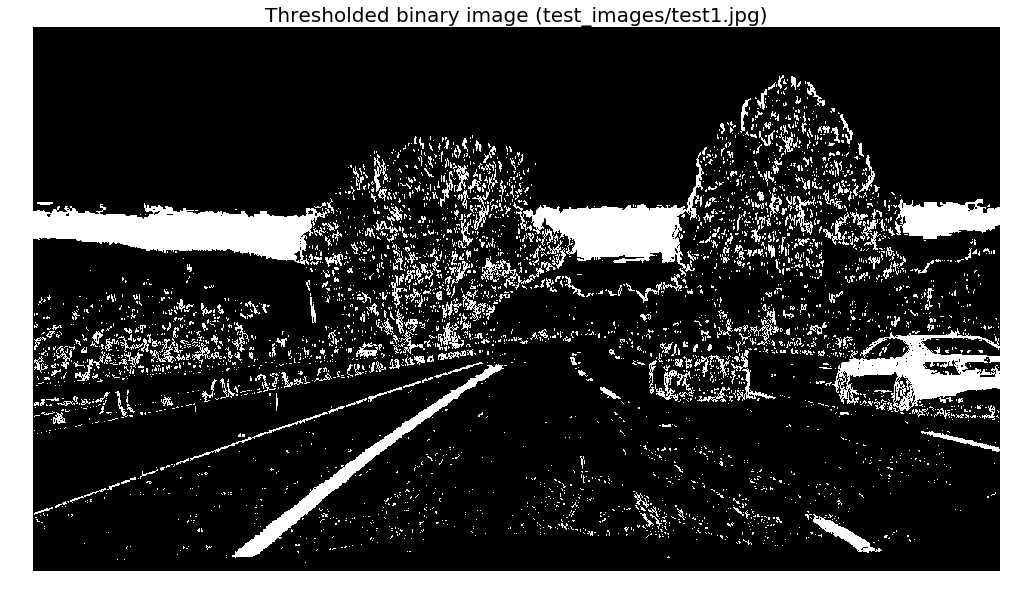

In [8]:
converted_image = convert_image(undist)
image_plotter(converted_image, title='Thresholded binary image ({})'.format(filename), cmap='gray')

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

Using an image with straight lane lines I selected points to create an isoceles trapezoid where the left and right lines overlay the lane lines. The image I used was `test_images/straight_lines1.jpg` and can be seen in the first example below. The points I selected can be seen in `src` variable below. Knowing the lane lines are supposed to look straight from above on this patch of the image I created `dst` points that form a rectangle. I added an offset from the left and right side that leaves room for curving lines. Then I get the transformation using these points with `cv2.getPerspectiveTransform`, as well as the inverse which will be used for transforming back from top-down view to our normal view. the `warp` function uses the transformation matrix to transform the image from our normal view to the top-down view. 

In [9]:
offset = 350
img_size = undist.shape[0:2][::-1]

src = np.array([[596,450],[685, 450],[1105,720], [205, 720]], np.int32)
src = src.reshape((-1,1,2))

dst = np.array([[0+offset, 0], [img_size[0]-offset, 0], [img_size[0]-offset, img_size[1]], [0+offset, img_size[1]]])
dst = dst.reshape((-1,1,2))

M = cv2.getPerspectiveTransform(np.float32(src), np.float32(dst))
Minv = cv2.getPerspectiveTransform(np.float32(dst), np.float32(src))

In [10]:
def warp(image):
     return cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

In [11]:
def draw_lines(image, points, color=(255, 0, 0)):
    # Polylines is destructive. Need a copy of the image to leave the old one
    # untouched
    return cv2.polylines(np.copy(image), np.int32([points]), True, color, 3)

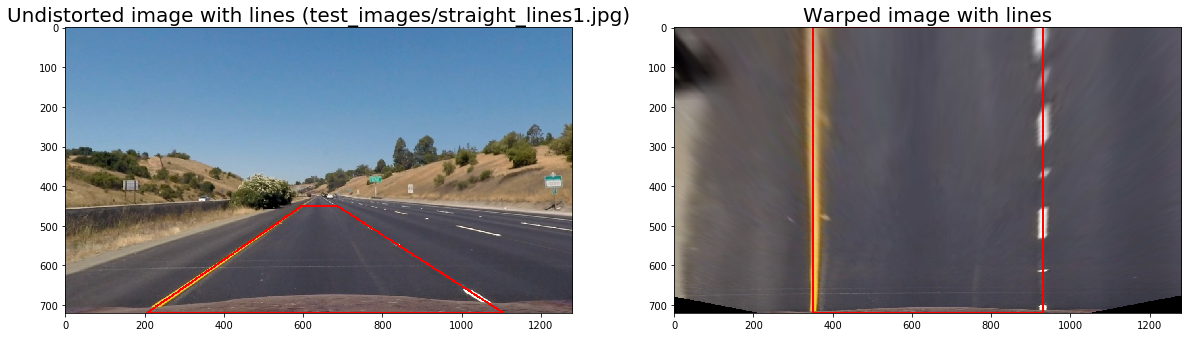

In [12]:
filename_straight = 'test_images/straight_lines1.jpg'
undist_straight = undistort(mpimg.imread(filename_straight))
warped_straight = warp(undist_straight)
undist_straight_lines = draw_lines(undist_straight, src)
warped_straight_lines = draw_lines(warped_straight, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted image with lines ({})'.format(filename_straight), fontsize=20)
ax1.imshow(undist_straight_lines)
ax2.set_title('Warped image with lines', fontsize=20)
ax2.imshow(warped_straight_lines)
plt.show()

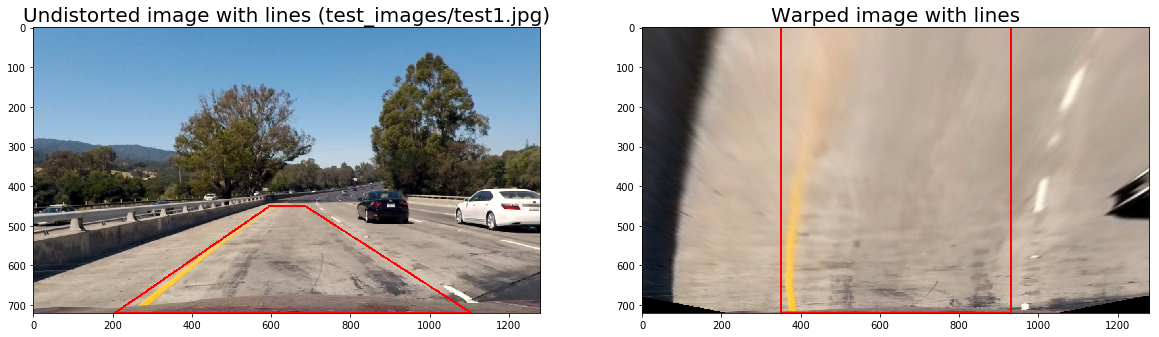

In [13]:
warped = warp(undist)
undist_lines = draw_lines(undist, src)
warped_lines = draw_lines(warped, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted image with lines ({})'.format(filename), fontsize=20)
ax1.imshow(undist_lines)
ax2.set_title('Warped image with lines', fontsize=20)
ax2.imshow(warped_lines)
plt.show()

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

First I get a histogram of the lower half binary warped image. This is used to identify where to start looking for lane lines. Then we look for parts of the lane lines in windows starting for the bottom. Then we use `np.polyfit` to fit a 2nd order polynomial to the points we identified as being part of lane lines. I then collect the data we created in this method and return it.

In [14]:
def fit_lanes(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangles, returned if we want them for visalization
    rectangles = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Collect the windows
        rectangles.append(((win_xleft_low,win_y_low), (win_xleft_high,win_y_high)))
        rectangles.append(((win_xright_low,win_y_low), (win_xright_high,win_y_high)))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fit, right_fit, left_fitx, right_fitx, left_lane_inds, right_lane_inds, rectangles

In [15]:
def visualize_fit_lanes(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    output_image = np.dstack((binary_warped, binary_warped, binary_warped))*255
    for rectangle in rectangles:
        cv2.rectangle(output_image, rectangle[0], rectangle[1], (0,255,0), 2)
    output_image[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    output_image[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    f, ax = plt.subplots(1, 1, figsize=(20,10))
    ax.imshow(output_image)
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()

Example of top down view of thresholded binary image with left and right lane identified. The 2nd order polynomial fitted to the poinds identified in the boxes are plotted in yellow.

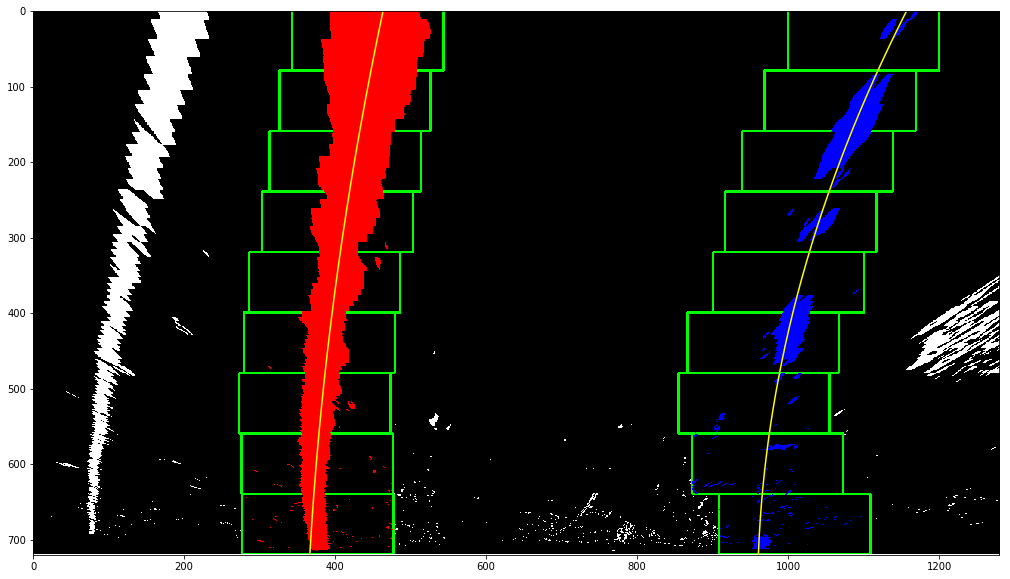

In [16]:
binary_warped = warp(convert_image(undist))
left_fit, right_fit, left_fitx, right_fitx, left_lane_inds,\
    right_lane_inds, rectangles = fit_lanes(binary_warped)
visualize_fit_lanes(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles)

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

For curve radius I first get new coefficients for curvature in the real world, not pixel space. Then calculate the radius with the new polynomial.

In [17]:
def curve_radius(image, fitx):
        ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
        y_eval = np.max(ploty)
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(ploty*ym_per_pix, fitx*xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        radius = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        return radius

In [18]:
curve_left = curve_radius(binary_warped, left_fitx)
curve_right = curve_radius(binary_warped, right_fitx)
print("Left curve radius: {:.2f}, right curge radius: {:.2f}".format(curve_left, curve_right))

Left curve radius: 1547.15, right curge radius: 504.49


This might seem like a rather large difference, but if we look at the actual curvature in the example above we see that the right lane fit is a lot more curved than the left one.

To get the distance from center I look at the lowest row of the image and find the x coordinates of the lanes. Then I get the centerpoint of both the lanes and the screen. I take the difference and multiply it with the meters per pixel ratio to get it in meters. If the number is negative the car is to the left of center. If it's greater than 0 it's to the right of center.

In [19]:
def center_distance(image, left_fit, right_fit):
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    y_eval = np.max(ploty)
    image_center = image.shape[1]/2
    left_lane = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_lane = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    lanes_center = (left_lane + right_lane)/2
    # meters per pixel in x dimension.
    # Lanes are rought 600 pixels apart at the lower end of the image
    xm_per_pix = 3.7/600
    meters_center = (image_center-lanes_center)*xm_per_pix
    return meters_center

In [20]:
center_distance(binary_warped, left_fit, right_fit)

-0.14578071314862079

Assuming the camera is mounted at the center of the car looking directly in the driving direction the car is roughly 0.15 meters to the left of the center of the lane in this image

#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

In [21]:
def draw_lane(undist, left_fit, right_fit, text=True):
    ploty = np.linspace(0, undist.shape[0]-1, undist.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw the lines on
    color_warp = np.zeros_like(undist).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    if text:
        curve_left = curve_radius(undist, left_fitx)
        curve_right = curve_radius(undist, right_fitx)
        curve_avg = (curve_left + curve_right)/2
        off_center = center_distance(image, left_fit, right_fit)
        
        radius_text = "Radius of curvature: {:.2f}m".format(curve_avg)
        center_dir = off_center < 0 and "left" or "right"
        center_text = "Vehicle is {:.2f}m {} of center".format(abs(off_center), center_dir)
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_color = (255., 255., 255.)
        
        cv2.putText(result, radius_text, (20, 40), font, 1.5, font_color, 2, cv2.LINE_AA)
        cv2.putText(result, center_text, (20, 80), font, 1.5, font_color, 2, cv2.LINE_AA)
    return result

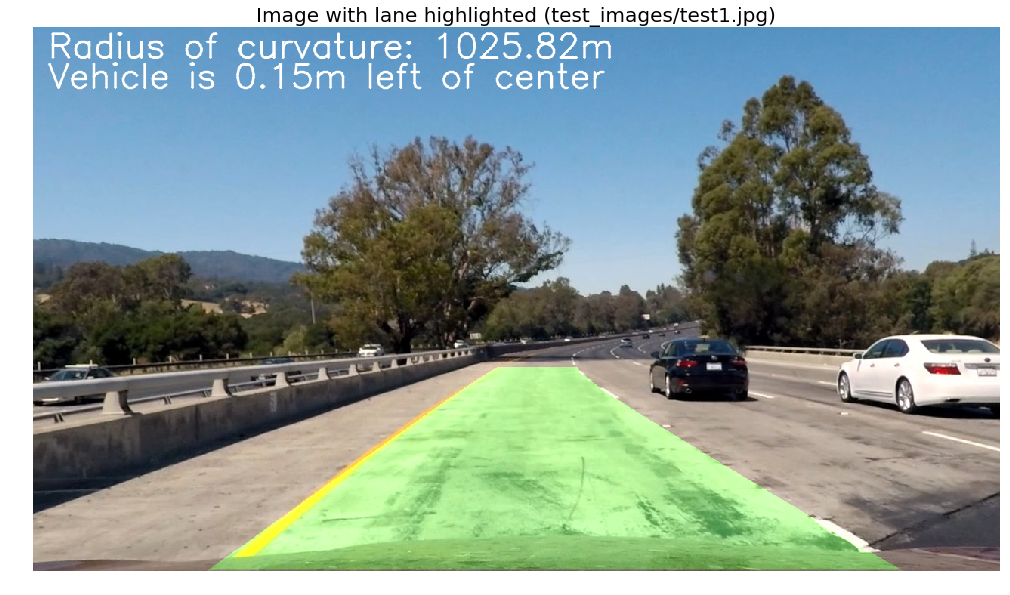

In [22]:
image_lane = draw_lane(undist, left_fit, right_fit)
image_plotter(image_lane, title='Image with lane highlighted ({})'.format(filename))

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Final video output is saved to [project_video_output.mp4](project_video_output.mp4)

In [23]:
class Line():
    def __init__(self, num_average=2):
        self.fit = []
        self.best_fit = []
        self.num_average = num_average
    def add_fit(self, fit, sane=True):
        if sane or len(self.fit) < 1:
            self.fit.append(fit)
        if len(self.fit) > self.num_average:
            self.fit.pop(0)
        self.best_fit = np.mean(self.fit, axis=0)

In [24]:
def sanity_check(left_fitx, right_fitx):
    ploty = np.linspace(0, undist.shape[0]-1, undist.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    distance_vector = [abs(rx-lx) for lx, rx in zip(left_fitx, right_fitx)]
    max_distance = max(distance_vector)
    if max_distance > 800:
        return False
    return True

In [25]:
left_line = Line()
right_line = Line()
def pipeline(image):
    undist = undistort(image)
    binary = convert_image(undist)
    warped = warp(binary)
    left_fit, right_fit, left_fitx, right_fitx, _, _, _ = fit_lanes(warped)
    sane = sanity_check(left_fitx, right_fitx)
    left_line.add_fit(left_fit, sane)
    right_line.add_fit(right_fit, sane)
    image_lane = draw_lane(undist, left_line.best_fit, right_line.best_fit)
    return image_lane

In [26]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_filename = 'project_video_output.mp4'
input_filename = 'project_video.mp4'

clip1 = VideoFileClip(input_filename)
output_clip = clip1.fl_image(pipeline)
%time output_clip.write_videofile(output_filename, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:16<00:00,  3.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 5min 22s, sys: 1min 20s, total: 6min 42s
Wall time: 6min 18s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_filename))